# Training a model to predict guide activity

## A measure of guide activity
In a recent study, we performed a pooled genome-wide screen with ~92,000 different guide RNAs targeting random positions along the chromosome of E. coli MG1655 (Cui et al. 2018). This screen, which was performed in rich medium, revealed a mysterious toxicity phenomenon that occurs when dCas9 is guided by guide RNAs that share specific 5 bases sequences at the 3’ of the guide RNA. This region is part of what is known as the seed sequence, and therefore this phenomenon was termed the “bad-seed” effect. Our data also revealed that off-target effects can occur with as little as 9nt of homology with the off-target position. Both the bad seed toxicity and off-target effect can be alleviated by fine tuning the expression level of dCas9. We thus previously constructed E. coli strain LC-E75, carrying dCas9 under the control of a Ptet promoter integrated at the 186 attB site in the chromosome of E. coli strain MG1655 (Cui et al. 2018). In this strain the ribosome binding site of dCas9 was optimised to enable strong on-target repression while limiting toxicity and off-target effects. While using strain LC-E75 improved the consistency of the results as compared to a strain where dCas9 expression was not optimized, we can still observe an important variability in the effect of guide RNAs that target within the same essential genes.

During growth of the library in a pool, guide RNAs that block the expression of essential or fitness genes are depleted from the library. The exact fold-change of each guide is a factor of the fitness defect produced when the target gene, or operon, is silenced and of how strongly the guide blocks the RNA polymerase. To take this gene effect into account, we computed as a measure of guide activity the difference between the log2 transformed fold change (log2FC) of a guide and the median log2FC of guides targeting the same gene. Our dataset contains 2765 guides targeting 247 genes with a median log2FC smaller than -2. 


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import pickle
from scipy.stats import spearmanr , pearsonr
from sklearn.linear_model import LinearRegression

data_path="data/"
cui2018data="https://gitlab.pasteur.fr/dbikard/badSeed_public/raw/master/screen_data.csv"
cui2018data=pd.read_csv(cui2018data,index_col=0)
cui2018data=cui2018data[cui2018data.ntargets==1]
cui2018data.head()

gene essential      pos ori coding     fit18     fit75  \
guide                                                                          
AAAAAACCTGCTGGTGAGGC   NaN       NaN  2202483   -    NaN -4.850012 -1.437546   
AAAAAACGTATTCGCTTGCA  curA     False  1517891   +  False -0.094026 -0.100313   
AAAAAAGCGCACTTTTTGAC   NaN       NaN  1919717   +    NaN -1.109310 -0.246740   
AAAAAAGCGGTGACTTACGA  bglA     False  3042929   +  False -1.328831 -0.905068   
AAAAAATCTGCCCGTGTCGT  gyrA      True  2337231   -  False -0.840373 -0.598858   

                      ntargets  \
guide                            
AAAAAACCTGCTGGTGAGGC         1   
AAAAAACGTATTCGCTTGCA         1   
AAAAAAGCGCACTTTTTGAC         1   
AAAAAAGCGGTGACTTACGA         1   
AAAAAATCTGCCCGTGTCGT         1   

                                                                    seq  
guide                                                                    
AAAAAACCTGCTGGTGAGGC  AAAGCAGATCACAGTAAATAAAAAAACCTGCTGGTGAGGCAGGTTC...  
AAAAAACGTATTCGCTTGCA  TGTTGATGGCTACAGTGCTGAAAAAACGTATTCGCTTGCAAGGTTT...  
AAAAAAGCGCACTTTTTGAC  GTAACGCCTGACAGCGCACAAAAAAAGCGCACTTTTTGACTGGCAC...  
AAAAAAGCGGTGACTTACGA  GCGCCCATATCGAAGAGATGAAAAAAGCGGTGACTTACGATGGCGT...  
AAAAAATCTGCCCGTGTCGT  ATGACTGGAACAAAGCCTATAAAAAATCTGCCCGTGTCGTTGGTGA...

In [2]:
cui2018dataGB=cui2018data.loc[cui2018data.coding==True,["gene","fit75"]].groupby("gene")
geneDF=cui2018dataGB.agg([len,np.median,np.mean,np.std])
geneDF.head()

from tqdm import tqdm
for g in tqdm(geneDF.index):
    cui2018data.loc[cui2018data.gene==g,"gene_median"]=geneDF.loc[g].fit75["median"]
    cui2018data.loc[cui2018data.gene==g,"gene_mean"]=geneDF.loc[g].fit75["mean"]
    cui2018data.loc[cui2018data.gene==g,"gene_std"]=geneDF.loc[g].fit75["std"]

100%|██████████████████████████████████████████████████████████████████████████████| 4066/4066 [02:05<00:00, 32.47it/s]


In [3]:
responsive_genes=geneDF[(geneDF.fit75.len>4) & (geneDF.fit75["median"]<-2)].index
data3=cui2018data.loc[(cui2018data.coding==True) & cui2018data.gene.isin(responsive_genes)].copy()
data3.shape, responsive_genes.shape

((2765, 12), (247,))

In [4]:
y=data3.gene_median-data3.fit75
data3["activity"]=y
data3.head()

gene essential      pos ori coding     fit18     fit75  \
guide                                                                          
AAAAGGCCAGACGCTCTTCC  dnaE      True   206022   -   True -5.633812 -4.517926   
AAAATGTGGCTTCGTCTCAA  pdxJ     False  2699503   +   True -2.119743 -0.887052   
AAACAACTTGCCCCAGAACT  cydA      True   770835   -   True -5.566825 -6.746593   
AAACACCCCAGTCGCGCAGG  leuS      True   672761   +   True -5.933861 -6.969073   
AAACACGAATCGGTAATTTA  pyrH      True   192484   -   True -4.392696 -4.149454   

                      ntargets  \
guide                            
AAAAGGCCAGACGCTCTTCC         1   
AAAATGTGGCTTCGTCTCAA         1   
AAACAACTTGCCCCAGAACT         1   
AAACACCCCAGTCGCGCAGG         1   
AAACACGAATCGGTAATTTA         1   

                                                                    seq  \
guide                                                                     
AAAAGGCCAGACGCTCTTCC  TTCTTCCTCATCAGGGAATAAAAAGGCCAGACGCTCTTCCAGGCCC...   
AAAATGTGGCTTCGTCTCAA  TTTTCCGGTACCAGGCAGCAAAAATGTGGCTTCGTCTCAACGGCGA...   
AAACAACTTGCCCCAGAACT  CCCAGAGCGAAGTTGATACCAAACAACTTGCCCCAGAACTTGGTCA...   
AAACACCCCAGTCGCGCAGG  GCCCCAGTAACGCTGACGGGAAACACCCCAGTCGCGCAGGCGGTAG...   
AAACACGAATCGGTAATTTA  ACCCGGTTTGTTCATATTGAAAACACGAATCGGTAATTTATGGTCA...   

                      gene_median  gene_mean  gene_std  activity  
guide                                                             
AAAAGGCCAGACGCTCTTCC    -4.475643  -4.355749  1.926164  0.042284  
AAAATGTGGCTTCGTCTCAA    -4.151922  -4.123183  1.742045 -3.264871  
AAACAACTTGCCCCAGAACT    -5.267122  -5.093094  1.241925  1.479471  
AAACACCCCAGTCGCGCAGG    -6.879588  -6.729146  1.715918  0.089486  
AAACACGAATCGGTAATTTA    -4.149454  -4.841783  1.780090  0.000000

In [10]:
data3.to_csv("data3.csv")

In [2]:
data3=pd.read_csv("data3.csv")

## Fitting a linear model


We first fitted a simple linear model with L1 regularization, using the primary sequence data of the target as features. This method highlighted the importance of the seed sequence of the guide, of the N in the NGG PAM, and interestingly of the sequence downstream of the PAM.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

#One-hot-encoding of the target sequence
bases=["A","T","G","C"]
def encode(seq):
    return np.array([[int(b==p) for b in seq] for p in bases])
    
def encode_seqarr(seq,r):
    '''One hot encoding of the sequence. r specifies the position range.'''
    X = np.array(
            [encode(''.join([s[i] for i in r])) for s in seq]
        )
    X = X.reshape(X.shape[0], -1)
    return X
    

def scorer_pearson(reg,X,y):
    return(pearsonr(reg.predict(X).flatten(),y.flatten())[0])

def scorer_spearman(reg,X,y):
    return(spearmanr(reg.predict(X).flatten(),y.flatten())[0])

# scaling the activity values
from sklearn import preprocessing
y=data3["activity"].values.reshape(-1, 1)

      
Xlin = encode_seqarr(data3["seq"],r=list(range(60)))
print(Xlin.shape)
#Fitting a L1 model

lassocv=LassoCV(cv=10,fit_intercept=False)
lassocv.fit(Xlin,y.ravel())
print("alpha  {:.3}".format(lassocv.alpha_))

from scipy.stats import pearsonr, spearmanr
cv_score=cross_val_score(lassocv,Xlin,y.ravel(),cv=10,scoring=scorer_pearson)
print("Pearson R: ",cv_score.mean(),cv_score.std())
cv_score=cross_val_score(lassocv,Xlin,y.ravel(),cv=10,scoring=scorer_spearman)
print("Spearman R: ",cv_score.mean(),cv_score.std())

(2765, 240)
alpha  0.0152
Pearson R:  0.3486424131760444 0.04980791278800867
Spearman R:  0.3424133755692121 0.03845792503691563


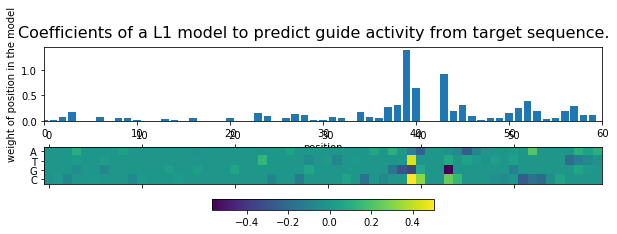

In [13]:
#plotting the coefficients
imp=np.abs(lassocv.coef_.reshape(4,-1)).sum(axis=0)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,3))
ax1.bar(range(int(Xlin.shape[1]/4)),imp,width=0.8)
#ax1.axvspan(20.5,22.5,color="red",alpha=0.2)
ax1.set_xlim(0,int(Xlin.shape[1]/4))
ax1.set_xlabel("position")
ax1.set_ylabel("weight of position in the model")

im=ax2.matshow(lassocv.coef_.reshape(4,-1))
ax2.set_yticklabels([""]+bases)
fig.colorbar(im,orientation="horizontal", pad=0.2)
fig.suptitle("Coefficients of a L1 model to predict guide activity from target sequence.",fontsize=16)
#plt.savefig("figures/weights_60bp.eps",format="eps")
plt.show()

### Feature selection (reduced sequence)
We then thought to determine the best sequence range to consider in our model. Starting from the three most important positions as the only features, we progressively increased the sequence range provided to the model in a stepwise manner using 10-fold cross-validation (Figure S1). The final sequence range we selected includes the last 6 bases of the guide, the N of the NGG PAM and the following 16 bases. A simple L1 regression model trained on this sequence data alone was able to predict guide activity with a Spearman correlation coefficient of 36.7 +/- 5.4 % (10-fold cross-validation average and standard deviation). 

Spearman R:  0.28913065874889615 0.04046281156700201


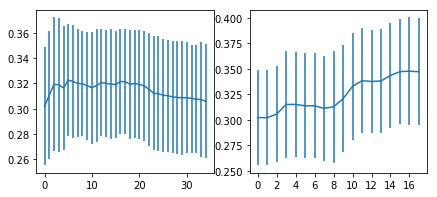

In [14]:
# Selecting sequence range

Xlin = encode_seqarr(data3["seq"],r=list([39,40,43]))
lasso=Lasso(alpha=0.01,fit_intercept=False)
cv_score=cross_val_score(lasso,Xlin,y,cv=10,scoring=scorer_spearman)
print("Spearman R: ",cv_score.mean(),cv_score.std())

sL=np.zeros((35,2))
for extraL in range(35):
    Xlin = encode_seqarr(data3["seq"],r=list(range(39-extraL,41))+[43])
    lasso=Lasso(alpha=0.01,fit_intercept=False)
    cv_score=cross_val_score(lasso,Xlin,y,cv=10,scoring=scorer_pearson)
    sL[extraL,:]=[cv_score.mean(),cv_score.std()]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(7,3))
ax1.errorbar(range(35),sL[:,0],sL[:,1])
ax2.set_xticks(range(0,18,2))

sR=np.zeros((18,2))
for extraR in range(18):
    Xlin = encode_seqarr(data3["seq"],r=[39,40,43]+list(range(43,43+extraR)))
    lasso=Lasso(alpha=0.01,fit_intercept=False)
    cv_score=cross_val_score(lasso,Xlin,y,cv=10,scoring=scorer_pearson)
    sR[extraR,:]=[cv_score.mean(),cv_score.std()]

ax2.errorbar(range(18),sR[:,0],sR[:,1])
ax2.set_xticks(range(0,18,2))
#plt.savefig("figures/feature_selection.eps",format="eps")
plt.show()

0.00573610820516602
Pearson R:  0.3665065892371626 0.05432523179082778
Spearman R:  0.358439066763852 0.04929112423482859


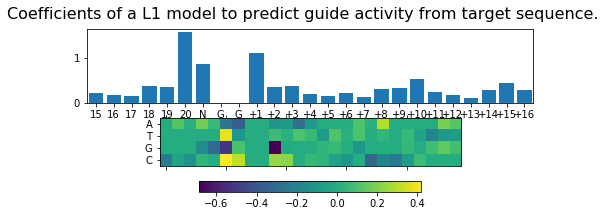

In [15]:
Xlin = encode_seqarr(data3["seq"],list(range(34,41))+list(range(43,59)))

# Selecting alpha through CV
lassocv=LassoCV(cv=10,fit_intercept=False)
lassocv.fit(Xlin,y.ravel())
print(lassocv.alpha_)

#Final model
reg=Lasso(alpha=lassocv.alpha_,fit_intercept=False)
reg.fit(Xlin,y)

cv_score=cross_val_score(reg,Xlin,y,cv=10,scoring=scorer_pearson)
print("Pearson R: ",cv_score.mean(),cv_score.std())
cv_score=cross_val_score(reg,Xlin,y,cv=10,scoring=scorer_spearman)
print("Spearman R: ",cv_score.mean(),cv_score.std())

#plotting the coefficients
coefs=reg.coef_.reshape(4,-1)
coefs=np.concatenate((coefs[:,:7],np.zeros((4,2)),coefs[:,7:]),axis=1)  #adding the PAM position to the representation
imp=np.abs(coefs).sum(axis=0)
L=int(Xlin.shape[1]/4)+2

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,3))
ax1.bar(np.arange(L)+0.5,imp,width=0.8)
#ax1.axvspan(20.5,22.5,color="red",alpha=0.2)
ax1.set_xlim(0,L)
ax1.set_xticks(np.arange(0,L)+0.5)
ax1.set_xticklabels([str(x) for x in range(15,21)]+["N","G","G"]+["+"+str(x) for x in range(1,21)])
ax1.set_xlabel("position")
#ax1.set_ylabel("weight of position in the model")

im=ax2.matshow(coefs)
ax2.set_yticklabels([""]+bases)
ax2.set_xticklabels("")
fig.colorbar(im,orientation="horizontal", pad=0.2)
#plt.savefig("figures/Ei_stdev_60bp.eps",format="eps")
fig.suptitle("Coefficients of a L1 model to predict guide activity from target sequence.",fontsize=16)
#plt.savefig("figures/weights_final_model.eps",format="eps")
plt.show()

In [29]:
# Save model weights to use for the website
with open("reg_coef.pkl","bw") as handle:
    reg.coef_.dump(handle)

In [ ]:
plt.scatter(reg.predict(Xlin),y,alpha=0.1)
plt.show()

## Evaluation of the model performance on LacZ repression
We then sought to obtain independent experimental validation that our model is able to predict how well guide RNAs can direct dCas9 to block transcription elongation. To this end 32 guides targeting the coding strand of lacZ where cloned on plasmid psgRNA and introduced in strain LC-E75. Residual B-galactosidase activity was measured after 6 hours of dCas9 induction through a Miller assay (Miller 1972). We observed a Spearman correlation coefficient of 70% (p-value ~10^-5) between the activity predicted by our model and how strongly the guides blocked the expression of lacZ. The better performance of our model on this validation dataset than on our training dataset can likely be explained by the fact that measuring residual B-galactosidase activity is a much more direct and cleaner measurement of dCas9 activity than what can be estimated from the log2FC of guides in a pooled CRISPR screen. This result highlights the fact that despite the noisy nature of activity measurements used to fit our model, we were able to capture biologically relevant features that are predictive of dCas9’s ability to block the RNAP.  

In [16]:
miller=pd.read_csv(data_path+"Miller.csv",sep=";")
miller.head()

guide_name             sequences  position       1_ind        r1  \
0     LacZ_1  CAGAGTTGCCCGGCGCTCTC    2068.0   44.581131  0.012873   
1     LacZ_5  ATGCGGGATGGCGTGGGACG    2201.0   77.157608  0.028541   
2     LacZ_6  CGTCGCCACCAATCCCCATA    2973.0  632.840229  0.295794   
3     LacZ_8  CAGGCGGCAGTAAGGCGGTC    2725.0   60.387990  0.020476   
4    LacZ_16  CGCCGATACTGACGGGCTCC    2999.0  819.330151  0.385486   

        2_ind        r2       3_ind        r3  
0   57.149839  0.020862   46.560433  0.009582  
1   89.702805  0.036346   71.728747  0.018400  
2  763.251195  0.356721  771.153485  0.263440  
3   46.702003  0.015893   52.295917  0.011592  
4  825.197765  0.386186  832.979202  0.285101

In [17]:
# Obtain the target sequence for each guide
with open(data_path+"lac_operon_region.fa") as handle:
    lac=handle.readlines()
    lac="".join([s.strip() for s in lac[1:]])
    lac=lac.upper()

def find_target(df):
    i=lac.find(df.sequences)
    return lac[i-20:i+40]

#get rid of control sequences
miller=miller[miller["guide_name"].str.contains("Lac")]
      
miller["target"]=miller.apply(find_target,axis=1)
miller["activity"]=miller[["r1","r2","r3"]].mean(axis=1)

miller.head()


guide_name             sequences  position       1_ind        r1  \
0     LacZ_1  CAGAGTTGCCCGGCGCTCTC    2068.0   44.581131  0.012873   
1     LacZ_5  ATGCGGGATGGCGTGGGACG    2201.0   77.157608  0.028541   
2     LacZ_6  CGTCGCCACCAATCCCCATA    2973.0  632.840229  0.295794   
3     LacZ_8  CAGGCGGCAGTAAGGCGGTC    2725.0   60.387990  0.020476   
4    LacZ_16  CGCCGATACTGACGGGCTCC    2999.0  819.330151  0.385486   

        2_ind        r2       3_ind        r3  \
0   57.149839  0.020862   46.560433  0.009582   
1   89.702805  0.036346   71.728747  0.018400   
2  763.251195  0.356721  771.153485  0.263440   
3   46.702003  0.015893   52.295917  0.011592   
4  825.197765  0.386186  832.979202  0.285101   

                                              target  activity  
0  GCACTACGCGTACTGTGAGCCAGAGTTGCCCGGCGCTCTCCGGCTG...  0.014439  
1  TCCATTTCGCTGGTGGTCAGATGCGGGATGGCGTGGGACGCGGCGG...  0.027762  
2  TACTGACGGGCTCCAGGAGTCGTCGCCACCAATCCCCATATGGAAA...  0.305318  
3  GCAGATCCCAGCGGTCAAAACAGGCGGCAGTAAGGCGGTCGGGATA...  0.015987  
4  CCGGCGCTCAGCTGGAATTCCGCCGATACTGACGGGCTCCAGGAGT...  0.352257

In [18]:
#encoding the target sequence
lac_seq=encode_seqarr(miller["target"],list(range(34,41))+list(range(43,59)))
lac_seq=lac_seq.reshape(lac_seq.shape[0],-1)
lac_seq.shape


(32, 92)

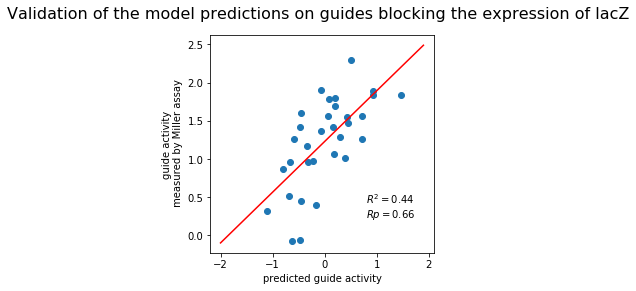

In [75]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model


x=reg.predict(lac_seq).reshape(-1, 1)
y_miller=-np.log10(miller["activity"].values)

Rp,pp=pearsonr(x.ravel(),y_miller)
Rs,ps=spearmanr(x,y_miller)

#linear regression line to plot
regr = linear_model.LinearRegression()
regr.fit(x,y_miller)
R2=r2_score(y_miller,regr.predict(x))

fig, ax= plt.subplots(1,1,figsize=(4,4))

fig.suptitle("Validation of the model predictions on guides blocking the expression of lacZ",fontsize=16)
ax.scatter(x,y_miller)
regline_x=np.arange(-2,2,0.1)
ax.plot(regline_x,regr.predict(regline_x.reshape(-1, 1)),c="red")
ax.text(0.8,0.2,"$R^2 = {:.2f}$\n$Rp = {:.2f}$".format(R2,Rp))
ax.set_xlabel("predicted guide activity")
ax.set_ylabel("guide activity\n measured by Miller assay")
#plt.savefig("figures/Miller_activity.eps",format="eps")
plt.show()

In [76]:
Rp, pp

(0.6641584674026941, 3.40087476948817e-05)

## Validating the model on the Hawkins et al., 2019 GFP data

In [23]:
Eco_rep1=pd.read_csv("https://raw.githubusercontent.com/traeki/mismatch_crispri/master/gfpdata/eco_biorep1.csv",index_col=0)
Eco_rep2=pd.read_csv("https://raw.githubusercontent.com/traeki/mismatch_crispri/master/gfpdata/eco_biorep2.csv",index_col=0)
Bsu_rep1=pd.read_csv("https://raw.githubusercontent.com/traeki/mismatch_crispri/master/gfpdata/bsu_biorep1.csv",index_col=0)
Bsu_rep2=pd.read_csv("https://raw.githubusercontent.com/traeki/mismatch_crispri/master/gfpdata/bsu_biorep2.csv",index_col=0)
GFPguides=pd.read_csv("https://raw.githubusercontent.com/traeki/mismatch_crispri/master/gfpdata/gfp.origmap.tsv",sep="\t",index_col=0)
GFPguides=GFPguides.join(Eco_rep1)
GFPguides=GFPguides.join(Eco_rep2,rsuffix="_Eco_rep2")
GFPguides=GFPguides.join(Bsu_rep1,rsuffix="_Bsu_rep1")
GFPguides=GFPguides.join(Bsu_rep2,rsuffix="_Bsu_rep2")

#Only keep the data from the parent guides
GFPguides_nomismatch=GFPguides[["original","parent","parent_Eco_rep2","parent_Bsu_rep1","parent_Bsu_rep2"]].copy()
GFPguides_nomismatch=GFPguides_nomismatch.drop_duplicates()
GFPguides_nomismatch.index=GFPguides_nomismatch.original
GFPguides_nomismatch=GFPguides_nomismatch.dropna()
GFPguides_nomismatch.describe()

parent  parent_Eco_rep2  parent_Bsu_rep1  parent_Bsu_rep2
count  33.000000        33.000000        33.000000        33.000000
mean   -0.637139        -0.699624        -0.666662        -0.678676
std     0.133892         0.134700         0.112821         0.122217
min    -0.830263        -0.856260        -0.787267        -0.798674
25%    -0.722781        -0.772949        -0.724923        -0.751925
50%    -0.659195        -0.721085        -0.701043        -0.734945
75%    -0.591443        -0.680727        -0.643580        -0.620814
max    -0.277513        -0.306984        -0.317398        -0.361015

In [24]:
#Using the mean of the two replicates as the score
GFPguides_nomismatch["Eco"]=GFPguides_nomismatch[["parent","parent_Eco_rep2"]].mean(axis=1)
GFPguides_nomismatch["Bsu"]=GFPguides_nomismatch[["parent_Bsu_rep1","parent_Bsu_rep2"]].mean(axis=1)

In [25]:
from Bio.Seq import Seq
GFP=Seq("ATGAGCAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATG\
GGCACAAATTTTCTGTCCGTGGAGAGGGTGAAGGTGATGCTACAAACGGAAAACTCACCCTTAAATTTAT\
TTGCACTACTGGAAAACTACCTGTTCCGTGGCCAACACTTGTCACTACTCTGACCTATGGTGTTCAATGC\
TTTTCCCGTTATCCGGATCACATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTAC\
AGGAACGCACTATATCTTTCAAAGATGACGGGACCTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGA\
TACCCTTGTTAATCGTATCGAGTTAAAGGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAA\
CTCGAGTACAACTTTAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTA\
ACTTCAAAATTCGCCACAACGTTGAAGATGGTTCCGTTCAACTAGCAGACCATTATCAACAAAATACTCC\
AATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGTCCTTTCGAAAGAT\
CCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGG\
ATGAGCTCTACAAATAA")

In [26]:
GFPrev=str(GFP.reverse_complement())
def find_target(df):
    i=GFPrev.find(df.original)
    return GFPrev[i-20:i+40]

GFPguides_nomismatch["target"]=GFPguides_nomismatch.apply(find_target,axis=1)

X=encode_seqarr(GFPguides_nomismatch["target"],list(range(34,41))+list(range(43,59)))
y_pred= reg.predict(X)
GFPguides_nomismatch['score']=y_pred

Spearman R:  0.36397058823529416 0.037319043676532423
Pearson R:  0.6253288718940168 9.98183175836056e-05
Spearman R:  0.3168449197860963 0.0724050312052051
Pearson R:  0.5270522162785509 0.0016248426430471314


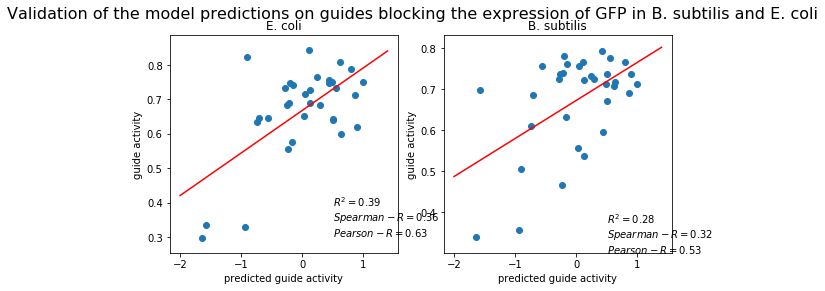

In [74]:
def reg_plot(x,y,ax):
    Rp,pp = pearsonr(x.ravel(),y)
    Rs,ps = spearmanr(x,y)
    print("Spearman R: ",Rs,ps)
    print("Pearson R: ",Rp,pp)


    ax.scatter(x,y)

    #linear regression line to plot
    regr = linear_model.LinearRegression()
    regr.fit(x,y)
    R2=r2_score(y,regr.predict(x))
    regline_x=np.arange(-2,1.5,0.1)
    ax.plot(regline_x,regr.predict(regline_x.reshape(-1, 1)),c="red")
    ax.text(0.5,0.3,"$R^2 = {:.2f}$\n$$Pearson-R = {:.2f}$".format(R2,Rs,Rp))
    return ax


fig, (ax1,ax2)=plt.subplots(1,2,figsize=(9,4))
fig.suptitle("Validation of the model predictions on guides blocking the expression of GFP in B. subtilis and E. coli",fontsize=16)

y=-GFPguides_nomismatch.Eco.values
x=GFPguides_nomismatch.score.values.reshape(-1, 1)

ax1=reg_plot(x,y,ax1)
ax1.title.set_text("E. coli")
ax1.set_xlabel("predicted guide activity")
ax1.set_ylabel("guide activity")

y=-GFPguides_nomismatch.Bsu.values
x=GFPguides_nomismatch.score.values.reshape(-1, 1)

ax2=reg_plot(x,y,ax2)
ax2.title.set_text("B. subtilis")
ax2.set_xlabel("predicted guide activity")
ax2.set_ylabel("guide activity")

plt.savefig("figures/GFP_validation.eps",format="eps")
plt.show()